In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")
TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")
GROQ_API_KEY = os.getenv("GROQ_API_KEY")
LANGCHAIN_API_KEY = os.getenv("LANGCHAIN_API_KEY")
LANGCHAIN_PROJECT = os.getenv("LANGCHAIN_PROJECT")
LANGSMITH_TRACING="true"
LANGSMITH_ENDPOINT="https://api.smith.langchain.com"
LANGSMITH_API_KEY= os.getenv("LANGSMITH_API_KEY")

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings
embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001")

In [5]:
from langchain_groq import ChatGroq
llm = ChatGroq(model_name="Llama3-8b-8192")

In [6]:
from typing import TypedDict, List
from langchain import hub
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain.tools.retriever import create_retriever_tool
from pydantic import BaseModel, Field
from langgraph.graph import StateGraph, START, END
import pprint

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [7]:
urls = ["https://lilianweng.github.io/posts/2023-06-23-agent/",
        "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
        "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
        ]

docs = [WebBaseLoader(url).load() for url in urls]

docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=100, chunk_overlap=25
)

doc_splits = text_splitter.split_documents(docs_list)

vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",
    embedding=embeddings
)

retriever = vectorstore.as_retriever()

In [8]:
retriever_tool = create_retriever_tool(retriever,
                      "retrieve_blog_posts",
                      "Search and return information about Lilian Weng blog posts on LLM agents, prompt engineering, and adversarial attacks on LLMs.You are a specialized assistant. Use the 'retriever_tool' **only** when the query explicitly relates to LangChain blog data. For all other queries, respond directly without using any tool. For simple queries like 'hi', 'hello', or 'how are you', provide a normal response.")

tools = [retriever_tool]

In [9]:
class GradeDocuments(BaseModel):
    """Binary score for relevence check on retrieved documents."""
    
    binary_score: str = Field(
        description="Documents are relevent to the question, 'yes' or 'no'"
    )

In [10]:
structured_llm_grader = llm.with_structured_output(GradeDocuments)

In [11]:
system = """You are a grader checking if a document is relevant to a user's question. The check has to be done very strictly.
If the document has words or meanings related to the question, mark it as relevant.
Give a simple 'yes' or 'no' answer to show if the document is relevant or not."""

grade_prompt = ChatPromptTemplate.from_messages([
    ("system", system),
    ("human", "Retrieved document: \n\n {document} \n\n User question: {question}")
])

In [12]:
retrieval_grader = grade_prompt | structured_llm_grader
question = "agent memory"
docs = retriever.get_relevant_documents(question)

C:\Users\Vikas Chauhan\AppData\Local\Temp\ipykernel_7908\4001347186.py:3: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  docs = retriever.get_relevant_documents(question)


In [13]:
docs

[Document(metadata={'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final results.\n\n\nMemory\n\nShort-term memory: I would consider all the in-context learning (See Prompt Engineering) as utiliz

In [14]:
doc_txt = docs[1].page_content

In [15]:
docs[1].page_content

'Planning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final results.\n\n\nMemory'

In [16]:
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))

binary_score='yes'


In [17]:
question = "who is elon musk?"
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))

binary_score='no'


In [18]:
prompt = hub.pull("rlm/rag-prompt")
prompt.pretty_print()

================================ Human Message =================================

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: {question} 
Context: {context} 
Answer:


In [19]:
rag_chain = prompt | llm

In [20]:
question = "agent memory"
generation = rag_chain.invoke({"context":docs, "question": question})
generation

AIMessage(content="The agent's memory is composed of both short-term memory, which enables in-context learning, and long-term memory, which allows it to retain and recall information over extended periods.", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 36, 'prompt_tokens': 1900, 'total_tokens': 1936, 'completion_time': 0.03, 'prompt_time': 0.235300116, 'queue_time': 0.250600974, 'total_time': 0.265300116}, 'model_name': 'Llama3-8b-8192', 'system_fingerprint': 'fp_179b0f92c9', 'finish_reason': 'stop', 'logprobs': None}, id='run--d82233f7-7f3c-4c6b-bd7a-99eca5b01435-0', usage_metadata={'input_tokens': 1900, 'output_tokens': 36, 'total_tokens': 1936})

In [21]:
class GradeHallucinations(BaseModel):
    """Binary score for hallucination present in generation answer."""
    
    binary_score: str = Field(
        description="Answer is grounded in the facts, 'yes' or 'no'"
    )

In [22]:
structured_llm_grader_hall = llm.with_structured_output(GradeHallucinations)

In [23]:
system = """You are a grader checking if an LLM generation is grounded in or supported by a set of retrieved facts.
Give a simple 'yes' or 'no' answer. 'Yes' means the generation is grounded in or supported by a set of retrieved the facts."""

hallucination_prompt = ChatPromptTemplate.from_messages([
    ("system", system),
    ("human", "Set of facts: \n\n {documents} \n\n LLM generation: {generation}")
])

In [24]:
hallucination_grader = hallucination_prompt | structured_llm_grader_hall

In [25]:
docs

[Document(metadata={'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final results.\n\n\nMemory\n\nShort-term memory: I would consider all the in-context learning (See Prompt Engineering) as utiliz

In [26]:
generation

AIMessage(content="The agent's memory is composed of both short-term memory, which enables in-context learning, and long-term memory, which allows it to retain and recall information over extended periods.", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 36, 'prompt_tokens': 1900, 'total_tokens': 1936, 'completion_time': 0.03, 'prompt_time': 0.235300116, 'queue_time': 0.250600974, 'total_time': 0.265300116}, 'model_name': 'Llama3-8b-8192', 'system_fingerprint': 'fp_179b0f92c9', 'finish_reason': 'stop', 'logprobs': None}, id='run--d82233f7-7f3c-4c6b-bd7a-99eca5b01435-0', usage_metadata={'input_tokens': 1900, 'output_tokens': 36, 'total_tokens': 1936})

In [27]:
print(hallucination_grader.invoke({"documents": docs, "generation": generation}))

BadRequestError: Error code: 400 - {'error': {'message': "Failed to call a function. Please adjust your prompt. See 'failed_generation' for more details.", 'type': 'invalid_request_error', 'code': 'tool_use_failed', 'failed_generation': 'yes'}}

In [28]:
class GradeAnswer(BaseModel):
    """Binary score to assess answer addresses question."""
    
    binary_score: str = Field(
        description= "Answer addresses the question, 'yes' or 'no'"
    )

In [29]:
structured_llm_grader_ans = llm.with_structured_output(GradeAnswer)

In [30]:
system = """You are a gender assessing whether an answer addresses / resolves a question \n
Give a binary score 'yes' or 'no'. 'yes' means that the answer resolves the question."""

answer_prompt = ChatPromptTemplate.from_messages([
    ("system", system),
    ("human", "User question: \n\n {question} \n\n LLM generation: {generation}")
])

In [31]:
answer_grader = answer_prompt | structured_llm_grader_ans

In [32]:
print(answer_grader.invoke({"question": question, "generation": generation}))

binary_score='no'


In [33]:
system = """You are a question re-writer that converts an input question into a better optimized version for vector store retrieval document.
You are given both a question and a document.
- First, check if the question is relevant to the document by identifying a connection or relevance between them.
- If there is a little relevancy, rewrite the question based on the semantic intect of the question and the context of the document.
- If no relevance is found, simply return this single word "question not relevant." dont return the entire phrase
Your goal is to ensure the rewritten question aligns well with the document for better retrieval."""

In [34]:
re_write_prompt = ChatPromptTemplate.from_messages([
    ("system", system),
    ("human", """Here is the initial question: \n\n {question} \n,
     Here is the document: \n\n {documents} \n ,
     Formulate an improved question. If possible other return 'question not relevant'.""")
])

In [35]:
question_rewriter = re_write_prompt | llm | StrOutputParser()

In [36]:
question = "who is the current indian prime minister?"

In [37]:
question_rewriter.invoke({"question":question,"documents":docs})

'The initial question is "Who is the current Indian prime minister?"\n\nAfter analyzing the provided document, I found that it is not relevant to the question. The document discusses LLM-powered autonomous agents, their components, and their capabilities. It does not mention anything about the current Indian prime minister.\n\nTherefore, I will return the simplified answer: "question not relevant".'

In [38]:
class AgentState(TypedDict):
    question: str
    generation: str
    documents: List[str]
    filter_documents: List[str]
    unfilter_documents: List[str]

In [39]:
def retrieve(state: AgentState):
    print("-----RETRIEVE-----")
    question = state['question']
    documents = retriever.get_relevant_documents(question)
    return {"documents": documents, "question": question}

In [40]:
def grade_documents(state: AgentState):
    print("-----CHECK DOCUMENTS RELEVANCE TO THE QUESTION-----")
    question = state['question']
    documents = state['documents']
    
    filtered_docs = []
    unfiltered_docs = []
    for doc in documents:
        score = retrieval_grader.invoke({"question":question, "document":doc})
        grade = score.binary_score
        
        if grade=='yes':
            print("-----GRADE: DOCUMENT RELEVANT-----")
            filtered_docs.append(doc)
        else:
            print("-----GRADE: DOCUMENT NOT RELEVANT-----")
            unfiltered_docs.append(doc)
    if len(unfiltered_docs)>1:
        return {"unfilter_documents": unfiltered_docs, "filter_documents":[], "question":question}
    else:
        return {"unfilter_documents": [], "filter_documents": filtered_docs, "question":question}

In [41]:
def decide_to_generate(state: AgentState):
    print("-----ACCESS GRADED DOCUMENTS-----")
    question = state["question"]
    unfiltered_documents = state["unfilter_documents"]
    filtered_documents = state["filter_documents"]
    
    if unfiltered_documents:
        print("-----ALL THE DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY-----")
        return "transform_query"
    if filtered_documents:
        print("-----DECISION: GENERATE-----")
        return "generate"
    

In [42]:
def generate(state:AgentState):
    print("-----GENERATE-----")
    question = state["question"]
    documents = state["documents"]
    
    generation = rag_chain.invoke({"context":documents, "question":question})
    return {"documents": documents, "question":question, "generation":generation}

In [43]:
def transform_query(state:AgentState):
    question = state["question"]
    documents = state["documents"]
    
    print(f"this is my documents{documents}")
    response = question_rewriter.invoke({"question":question, "documents":documents})
    print(f"-----RESPONSE----- {response}")
    if response == 'question not relevant':
        print("-----QUESTION IS NOT AT ALL RELEVANT-----")
        return {"documents":documents, "question": response, "generation": "question was not at all relevant"}
    else:
        return {"documents":documents, "question":response}

In [44]:
def decide_to_generate_after_transformation(state:AgentState):
    question = state["question"]
    if question == "question not relevant":
        return "query_not_at_all_relevant"
    else:
        return "Retriever"

In [45]:
def grade_generation_vs_documents_and_question(state:AgentState):
    print("-----CHECK HELLUCINATIONS-----")
    question = state['question']
    documents = state['documents']
    generation = state['generation']
    
    score = hallucination_grader.invoke({"documents":documents, "generation":generation})
    
    grade = score.binary_score
    
    if grade == 'yes':
        print("-----DECISION: GENERATION IS GROUNDED IN DOCUMENTS-----")
        print("-----GRADE GENERATION vs QUESTION-----")
        score = answer_grader.invoke({"question":question, "generation":generation})
        
        grade = score.binary_score
        
        if grade=='yes':
            print("-----DECISION: GENERATION ADDRESS THE QUESTION-----")
            return "useful"
        else:
            print("-----DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---TRANSFORM QUERY")
            return "not useful"        
    else:
        pprint("-----DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---TRANSFORM QUERY")
        "not useful"

In [46]:
workflow = StateGraph(AgentState)
workflow.add_node("Docs_Vector_Retrieve", retrieve)
workflow.add_node("Grading_Generated_Documents", grade_documents)
workflow.add_node("Content_Generator", generate)
workflow.add_node("Transform_User_Query", transform_query)
workflow.add_edge(START,"Docs_Vector_Retrieve")
workflow.add_edge("Docs_Vector_Retrieve", "Grading_Generated_Documents")
workflow.add_conditional_edges("Grading_Generated_Documents", decide_to_generate, 
                               {"generate":"Content_Generator", "transform_query":"Transform_User_Query"})
workflow.add_conditional_edges("Content_Generator", grade_generation_vs_documents_and_question, 
                               {"useful": END, "not_useful": "Transform_User_Query"})
workflow.add_conditional_edges("Transform_User_Query", decide_to_generate_after_transformation, 
                               {"Retriever": "Docs_Vector_Retrieve", "query_not_at_all_relevant": END})
app = workflow.compile()

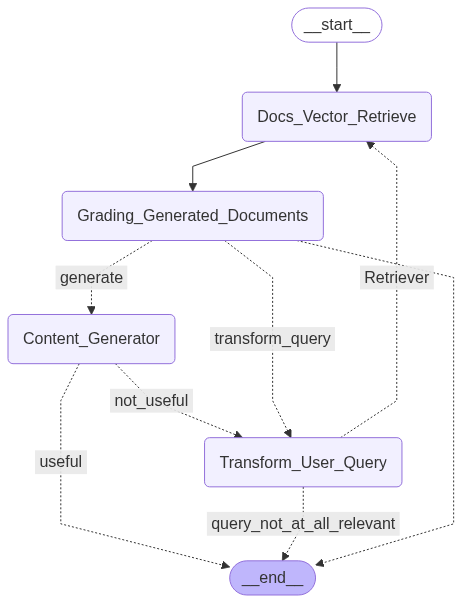

In [47]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [48]:
inputs = {"question": "Explain how the different types of agent memory work?"}
app.invoke(inputs)['generation']

-----RETRIEVE-----
-----CHECK DOCUMENTS RELEVANCE TO THE QUESTION-----
-----GRADE: DOCUMENT RELEVANT-----
-----GRADE: DOCUMENT NOT RELEVANT-----
-----GRADE: DOCUMENT RELEVANT-----
-----GRADE: DOCUMENT NOT RELEVANT-----
-----ACCESS GRADED DOCUMENTS-----
-----ALL THE DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY-----
this is my documents[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'language': 'en', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key 

BadRequestError: Error code: 400 - {'error': {'message': "Failed to call a function. Please adjust your prompt. See 'failed_generation' for more details.", 'type': 'invalid_request_error', 'code': 'tool_use_failed', 'failed_generation': 'yes'}}

In [49]:
inputs = {"question": "who is a prompt engineering?"}
app.invoke(inputs)["generation"]

-----RETRIEVE-----
-----CHECK DOCUMENTS RELEVANCE TO THE QUESTION-----
-----GRADE: DOCUMENT NOT RELEVANT-----
-----GRADE: DOCUMENT RELEVANT-----
-----GRADE: DOCUMENT RELEVANT-----
-----GRADE: DOCUMENT NOT RELEVANT-----
-----ACCESS GRADED DOCUMENTS-----
-----ALL THE DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY-----
this is my documents[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/', 'title': "Prompt Engineering | Lil'Log", 'language': 'en', 'description': 'Prompt Engineering, also known as In-Context Prompting, refers to methods for how to communicate with LLM to steer its behavior for desired outcomes without updating the model weights. It is an empirical science and the effect of prompt engineering methods can vary a lot among models, thus requiring heavy experimentation and heuristics.\nThis post only focuses on prompt engineering for autoregressive language models, so nothing with Cloze tests, image generation or multimoda

AIMessage(content='According to the document, the methods of prompt engineering aim to communicate with LLM to steer its behavior for desired outcomes without updating the model weights, and the effect of these methods can vary greatly among models. The goal of prompt engineering is about alignment and model steerability, requiring heavy experimentation and heuristics.', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 63, 'prompt_tokens': 1144, 'total_tokens': 1207, 'completion_time': 0.0525, 'prompt_time': 0.142816943, 'queue_time': 0.24725556699999998, 'total_time': 0.195316943}, 'model_name': 'Llama3-8b-8192', 'system_fingerprint': 'fp_179b0f92c9', 'finish_reason': 'stop', 'logprobs': None}, id='run--c18bb424-5d9e-4c62-85f7-addac5c4385a-0', usage_metadata={'input_tokens': 1144, 'output_tokens': 63, 'total_tokens': 1207})

In [50]:
inputs = {"question": "what is role of data structure while creating ai agentic pattern?"}

In [51]:
app.invoke(inputs)

-----RETRIEVE-----
-----CHECK DOCUMENTS RELEVANCE TO THE QUESTION-----
-----GRADE: DOCUMENT RELEVANT-----
-----GRADE: DOCUMENT RELEVANT-----
-----GRADE: DOCUMENT NOT RELEVANT-----
-----GRADE: DOCUMENT NOT RELEVANT-----
-----ACCESS GRADED DOCUMENTS-----
-----ALL THE DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY-----
this is my documents[Document(metadata={'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling effi

BadRequestError: Error code: 400 - {'error': {'message': "Failed to call a function. Please adjust your prompt. See 'failed_generation' for more details.", 'type': 'invalid_request_error', 'code': 'tool_use_failed', 'failed_generation': 'yes'}}

In [52]:
inputs = {"question": "what is role of c language and php while creating ai agentic pattern?"}
app.invoke(inputs)

-----RETRIEVE-----
-----CHECK DOCUMENTS RELEVANCE TO THE QUESTION-----
-----GRADE: DOCUMENT NOT RELEVANT-----
-----GRADE: DOCUMENT NOT RELEVANT-----
-----GRADE: DOCUMENT NOT RELEVANT-----
-----GRADE: DOCUMENT NOT RELEVANT-----
-----ACCESS GRADED DOCUMENTS-----
-----ALL THE DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY-----
this is my documents[Document(metadata={'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabl

BadRequestError: Error code: 400 - {'error': {'message': "Failed to call a function. Please adjust your prompt. See 'failed_generation' for more details.", 'type': 'invalid_request_error', 'code': 'tool_use_failed', 'failed_generation': 'yes'}}

In [ ]:
inputs = {"question": "who is a first president of USA?"}
app.invoke(inputs)["generation"]